<a href="https://colab.research.google.com/github/shelausadi/Thinkful-DataScienceBootcamp/blob/master/Capstones/Final_Capstone/Detecting_Skin_Cancer_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detecting Skin Cancer with Deep Learning


##Background and Objective

Skin cancer is the most prevalent type of cancer worldwide and kills thousands of people every year. In the United States alone, more than 9,500 people are diagnosed with skin cancer every day and more than two people die from the disease every hour. However, it is also often difficult to detect by the naked eye. In fact, diagnosis by medical experts currently only have a 77.0344% accuracy. 

I want to utilize current images of diagnosed skin lesions and write an algorithm that detects skin cancer more accurately than unaided visual inspection by physicians.

I am planning to enter my solution into the ISIC 2019 competition (Deadline: August 9th). If used and adapted, it will be able to help diagnose skin cancer easier, faster, cheaper and with more accuracy. Early detection of certain types of skin cancer will help save lives and increase the chance of survival for patients. 

Our data source comes from the [International Skin Imaging Collaboration (ISIC) website ](https://challenge2019.isic-archive.com/data.html) in the form of 2 CSV files and 25,331 images. 

##Mount Google Drive
We are using Google Drive to store the files needed for this project so the first step is to mount Google Drive into our Colab notebook.

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [17]:
!ls '/gdrive/My Drive/ISIC_2019_data'

'Detecting Skin Cancer with Deep Learning.ipynb'
 ISIC_2019_Training_GroundTruth.csv
 ISIC_2019_Training_Input
 ISIC_2019_Training_Metadata.csv
 models
 truelabels.csv


##Import Modules
Importing the necessary modules for this project.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import numpy as np

##Open CSV files from Google Cloud Storage
The ISIC data include 2 csv files we can analyze: groundtruth.csv and metadata.csv.

In [0]:
groundtruth = pd.read_csv('/gdrive/My Drive/ISIC_2019_data/ISIC_2019_Training_GroundTruth.csv')

In [0]:
metadata = pd.read_csv('/gdrive/My Drive/ISIC_2019_data/ISIC_2019_Training_Metadata.csv')

##Cleaning the Data

Do we have any missing data in the dataset?

In [21]:
metadata.isnull().sum()

image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dtype: int64

Let's remove the columns with missing data from the dataset.

In [0]:
metadata = metadata.dropna()

In [23]:
metadata.head(3)

,image,age_approx,anatom_site_general,lesion_id,sex
1459,ISIC_0012653_downsampled,50.0,posterior torso,MSK4_0011169,female
1460,ISIC_0012654_downsampled,30.0,lower extremity,MSK4_0011170,female
1461,ISIC_0012655_downsampled,35.0,upper extremity,MSK4_0011171,female


##Exploratory Data Analysis

In [24]:
groundtruth.shape

(25331, 10)

In [25]:
metadata.shape

(21311, 5)

What is the most common age of skin cancer patients in this dataset?
What is the most common body part where skin cancer has been found in this dataset?
What is the most common sex of skin cancer patients in this dataset?

In [26]:
metadata[['age_approx','anatom_site_general', 'sex']].mode()

,age_approx,anatom_site_general,sex
0,45.0,anterior torso,male


What is the distribution of images by tags in the dataset?

In [27]:
total = groundtruth.sum()
total_df = pd.DataFrame(data=total, columns=['total'])
total_df = total_df.drop(['image']).sort_values(by='total',ascending=False).reset_index()
total_df = total_df.rename(columns = {"index": "tags"}) 
total_df 

,tags,total
0,NV,12875
1,MEL,4522
2,BCC,3323
3,BKL,2624
4,AK,867
5,SCC,628
6,VASC,253
7,DF,239
8,UNK,0


The tags represent the diagnosis for each picture. UNK stands for unknown.

####Legend
* melanoma (MEL)
* melanocytic nevus (NV)
* basal cell carcinoma (BCC)
* actinic keratosis (AK)
* benign keratosis (BKL)
* dermatofibroma (DF)
* vascular lesion (VASC)

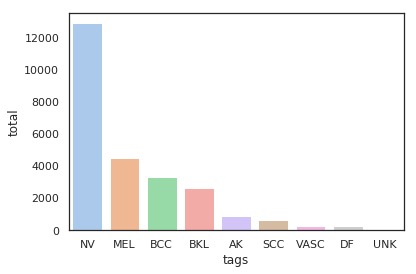

In [28]:
sns.set(style='white')
sns.barplot(x='tags', y='total', data=total_df, palette='pastel');

It looks like there's a disporpotionate number of NV images. We will have to take this into consideration when training our data. 

What is the distribution of the age of patients in this dataset?

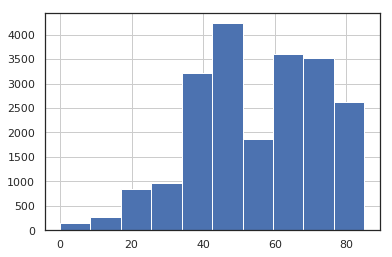

In [29]:
metadata['age_approx'].hist();

What is the distribution for sexes in this dataset?

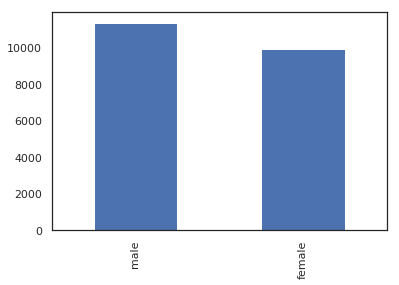

In [30]:
metadata['sex'].value_counts().plot.bar();

Which areas of our bodies are most compromised to skin cancer?

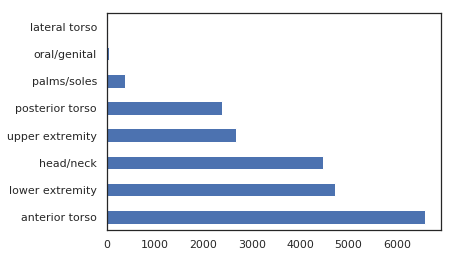

In [31]:
metadata['anatom_site_general'].value_counts().plot.barh();

###Correlation

Do any of our attributes have high correlation? Do the odds of getting melanoma vary depending on a person's age, gender, etc.? As a woman, am I more likely to get skin cancer on certain parts of my body than others?

In [32]:
data = pd.merge(metadata, groundtruth, on='image')
data.head(5) 

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0012653_downsampled,50.0,posterior torso,MSK4_0011169,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0012654_downsampled,30.0,lower extremity,MSK4_0011170,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0012655_downsampled,35.0,upper extremity,MSK4_0011171,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0012656_downsampled,45.0,posterior torso,MSK4_0011172,male,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0012657_downsampled,20.0,upper extremity,MSK4_0011173,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
data = data.drop(['lesion_id'], axis=1)

In [34]:
numeric = data[['age_approx','MEL', 'NV','BCC','AK','BKL','DF','VASC','SCC','UNK']]
nonnumeric = data[['anatom_site_general', 'sex']]
one_hot = pd.get_dummies(nonnumeric)
one_hot.head(5)

,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lateral torso,anatom_site_general_lower extremity,anatom_site_general_oral/genital,anatom_site_general_palms/soles,anatom_site_general_posterior torso,anatom_site_general_upper extremity,sex_female,sex_male
0,0,0,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,1,1,0


In [35]:
one_hot_data = numeric.join(one_hot) 
one_hot_data.head(5)

,age_approx,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lateral torso,anatom_site_general_lower extremity,anatom_site_general_oral/genital,anatom_site_general_palms/soles,anatom_site_general_posterior torso,anatom_site_general_upper extremity,sex_female,sex_male
0,50.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,1,0
1,30.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,0
2,35.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0
3,45.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,1
4,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0


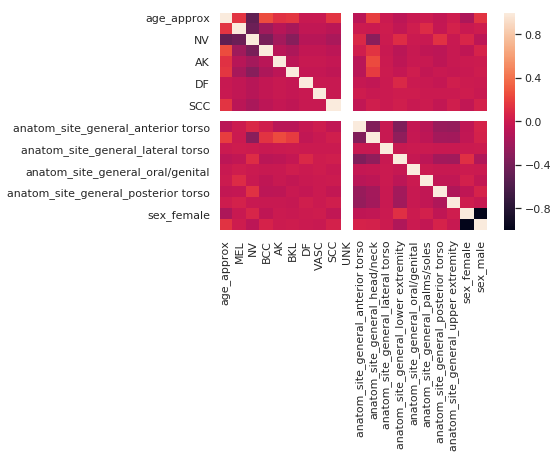

In [36]:
sns.set(style='white')
sns.heatmap(one_hot_data.corr());

In [37]:
one_hot_data.corr()['MEL'].sort_values(ascending=False).head(10)

MEL                                    1.000000
age_approx                             0.155374
anatom_site_general_palms/soles        0.105355
anatom_site_general_upper extremity    0.047432
anatom_site_general_oral/genital       0.017322
anatom_site_general_lateral torso      0.015550
sex_male                               0.012582
anatom_site_general_anterior torso     0.005012
anatom_site_general_head/neck         -0.004677
sex_female                            -0.012582
Name: MEL, dtype: float64

In [38]:
one_hot_data.corr()['sex_female'].sort_values(ascending=False).head(10)

sex_female                             1.000000
anatom_site_general_lower extremity    0.130057
NV                                     0.076396
anatom_site_general_palms/soles        0.039990
anatom_site_general_upper extremity    0.018617
VASC                                   0.010514
DF                                     0.005656
anatom_site_general_oral/genital       0.002601
AK                                    -0.003146
anatom_site_general_lateral torso     -0.006185
Name: sex_female, dtype: float64

###Further Data Analysis with Pandas Profiling
Pandas Profiling is a quick and easy way to cover further analysis of the dataset and help answer questions we might not even have thought of.

In [39]:
import pandas_profiling
pandas_profiling.ProfileReport(data)

Number of variables,13
Number of observations,21311
Total Missing (%),0.0%
Total size in memory,2.9 MiB
Average record size in memory,142.8 B
Numeric,1
Categorical,2
Boolean,8
Date,0
Text (Unique),1
Rejected,1


##Get Image List and Train/Test Split



In this part, we use truelabels.csv and the images we uploaded in Google Drive to create an ImageList. 
Here, we are also splitting the data into training and test set. We are going to undersample the training and test set for two reasons:

1) Our dataset is large and Colab will not be able to handle it. If our alghoritm works, we can use other platforms to fun it.

2) We have an inbalance in the dataset. Undersampling balances the dataset by reducing the size of the abundant class.




###Reverse one hot encoding 
We need a column that has the diagnosis for each picture to create an ImageList but the diagnosis has already been one hot encoded in the csv we received. Thus, we need to reverse the one hot encoding.

In [0]:
#diagnosis = pd.get_dummies(groundtruth).idxmax(1)

In [0]:
#groundtruth['diagnosis'] = diagnosis 

In [0]:
#groundtruth.head(10)

In [0]:
#truelabels = groundtruth[['image', 'diagnosis']]

In [0]:
#truelabels.head(10)

In [45]:
#This saves truelabels into our Google Drive folder in the csv format. 
#We only need to do this once and should leave it out or comment it out when running this notebook more than once.
truelabels.to_csv(r'/gdrive/My Drive/ISIC_2019_data/truelabels.csv', index=False)

NameError: ignored

###Train/Test Split

In [0]:
%reload_ext autoreload
%autoreload 2
from fastai.vision import *

In [0]:
#create list of random indices
from numpy.random import RandomState
random_indices = np.random.randint(low=0, high=25331, size=1500)

In [0]:
#this are to be used in the split by index
train_indices = list(random_indices[0:math.floor(len(random_indices)*0.7)])
test_indices  = list(random_indices[math.floor(len(random_indices)*0.7):])

###Get ImageList

In [0]:
path = Path('/gdrive/My Drive/ISIC_2019_data/')

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, '/gdrive/My Drive/ISIC_2019_data/truelabels.csv', folder='ISIC_2019_Training_Input', suffix='.jpg')
       #.split_by_rand_pct(0.8)
       .split_by_idxs(train_idx=train_indices, valid_idx=test_indices)
       .label_from_df())

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize())

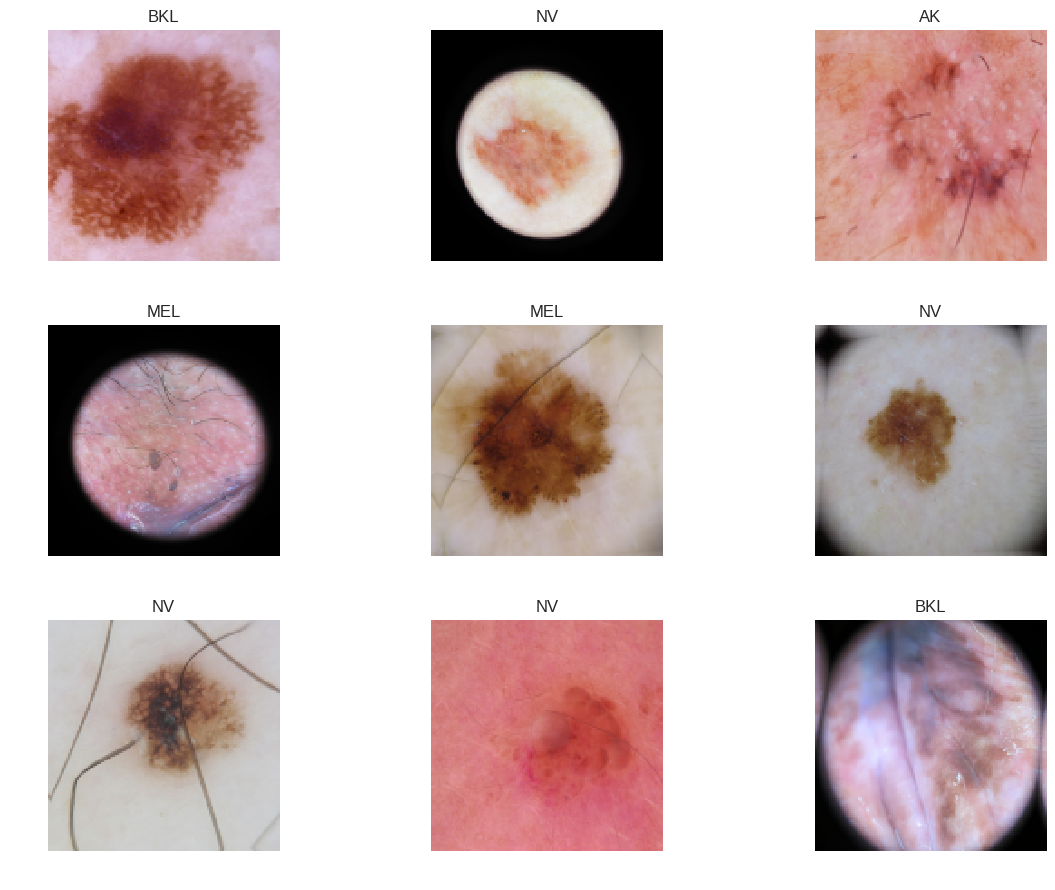

In [53]:
data.show_batch(rows=3, figsize=(12,9))

##Training: resnet34

In [54]:
learn_resnet34 = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 25706656.94it/s]


In [55]:
learn_resnet34.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [56]:
learn_resnet34.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.325518,1.479688,0.468889,01:07
1,1.911445,1.155980,0.368889,00:21
2,1.622040,1.108254,0.384444,00:21
3,1.472068,1.092388,0.373333,00:21


In [0]:
learn_resnet34.save('stage-1')

In [58]:
interp = ClassificationInterpretation.from_learner(learn_resnet34)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

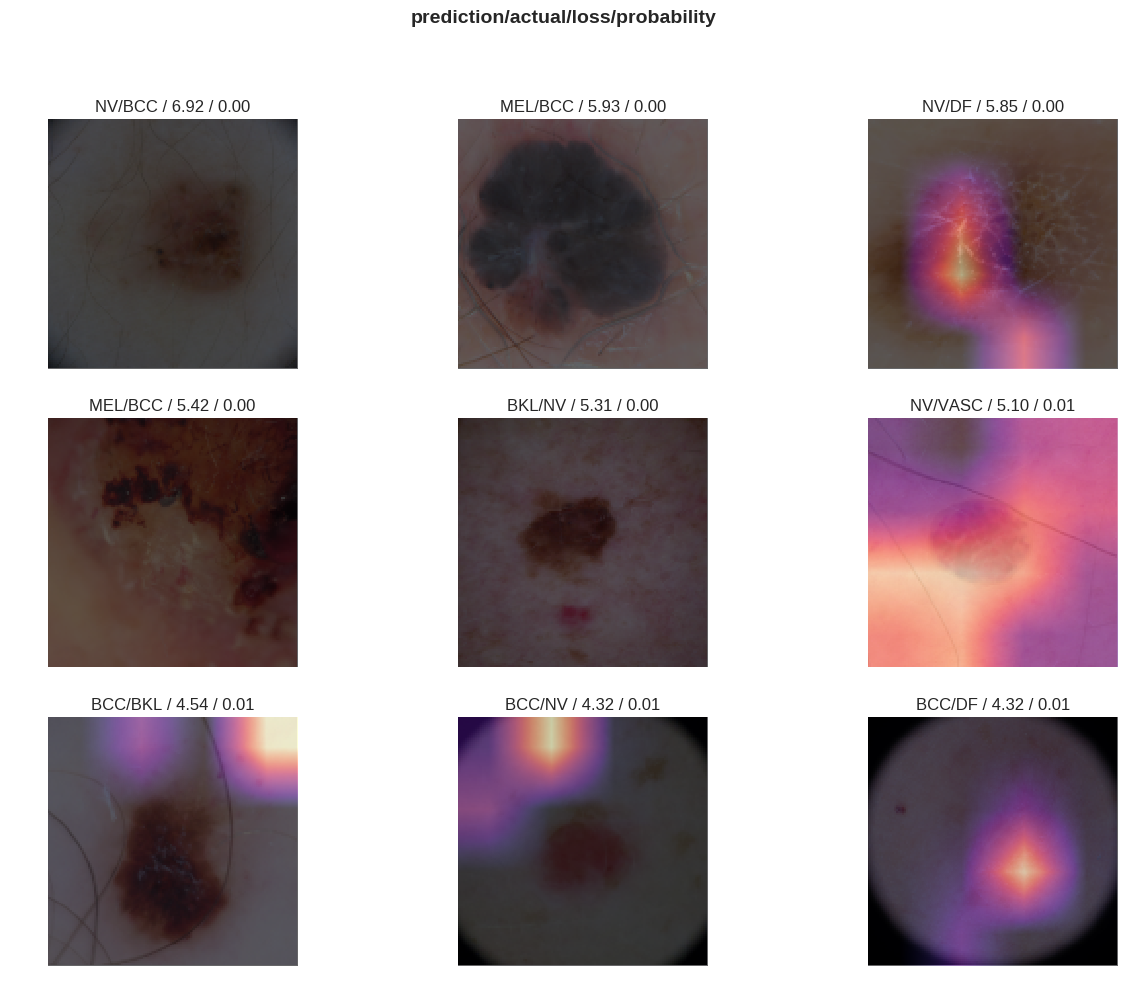

In [59]:
interp.plot_top_losses(9, figsize=(15,11))

In [60]:
doc(interp.plot_top_losses)

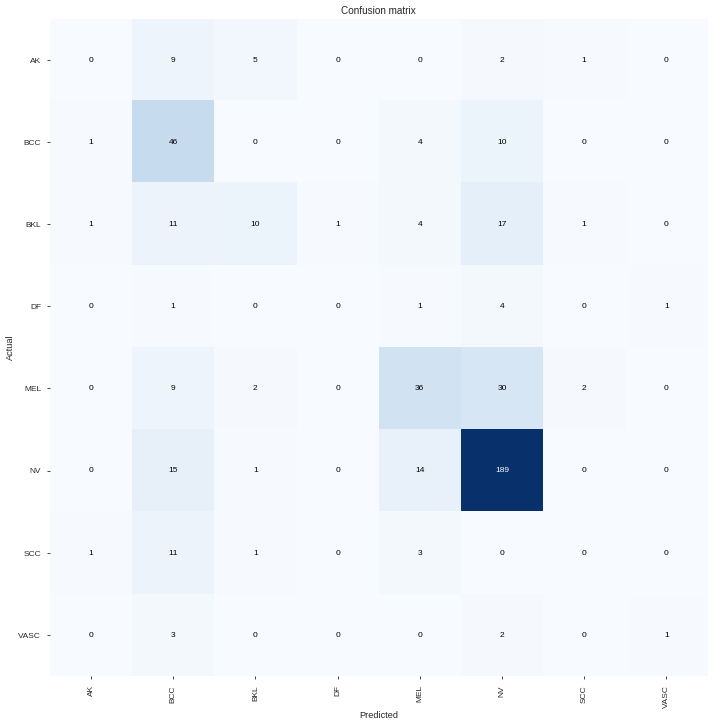

In [61]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [62]:
interp.most_confused(min_val=2)

[('MEL', 'NV', 30),
 ('BKL', 'NV', 17),
 ('NV', 'BCC', 15),
 ('NV', 'MEL', 14),
 ('BKL', 'BCC', 11),
 ('SCC', 'BCC', 11),
 ('BCC', 'NV', 10),
 ('AK', 'BCC', 9),
 ('MEL', 'BCC', 9),
 ('AK', 'BKL', 5),
 ('BCC', 'MEL', 4),
 ('BKL', 'MEL', 4),
 ('DF', 'NV', 4),
 ('SCC', 'MEL', 3),
 ('VASC', 'BCC', 3),
 ('AK', 'NV', 2),
 ('MEL', 'BKL', 2),
 ('MEL', 'SCC', 2),
 ('VASC', 'NV', 2)]

In [0]:
learn_resnet34.unfreeze()

In [64]:
learn_resnet34.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.242433,1.232487,0.382222,00:21


In [0]:
learn_resnet34.load('stage-1');

In [66]:
learn_resnet34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


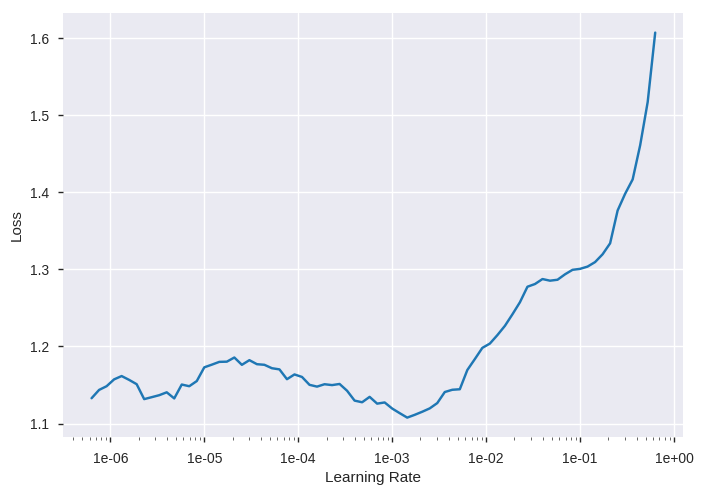

In [67]:
learn_resnet34.recorder.plot()

In [68]:
learn_resnet34.unfreeze()
learn_resnet34.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.140526,1.076634,0.373333,00:21
1,1.158643,1.077311,0.373333,00:21


## Training: resnet50

In [69]:
learn_resnet50 = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 23799096.42it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


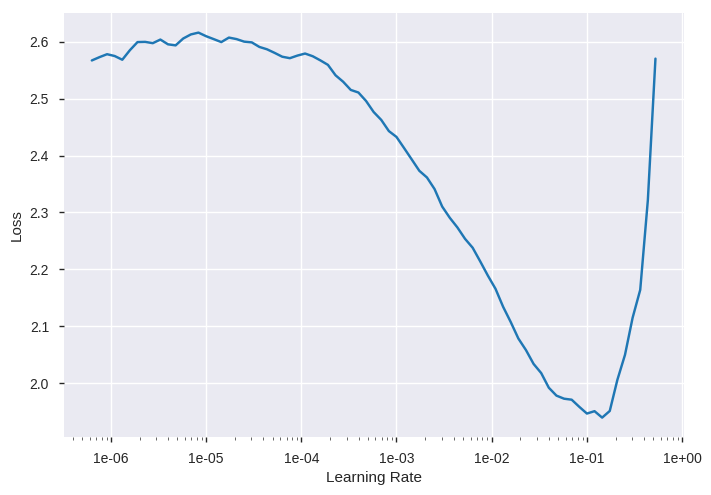

In [70]:
learn_resnet50.lr_find()
learn_resnet50.recorder.plot()

In [71]:
learn_resnet50.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.263480,1.452136,0.433333,00:22
1,1.892496,1.376574,0.397778,00:22
2,1.639028,1.286548,0.355556,00:22
3,1.428530,1.083154,0.351111,00:22
4,1.251274,1.071764,0.333333,00:22
5,1.112276,1.050666,0.351111,00:22
6,1.016345,1.025084,0.335556,00:22
7,0.952720,1.025912,0.337778,00:22


In [0]:
learn_resnet50.save('stage-1-50')

In [73]:
learn_resnet50.unfreeze()
learn_resnet50.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.754380,1.017246,0.331111,00:22
1,0.752769,1.022716,0.333333,00:22
2,0.748339,1.011651,0.328889,00:22


In [74]:
learn_resnet50.load('stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (1050 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
NV,SCC,NV,NV,SCC
Path: /gdrive/My Drive/ISIC_2019_data;

Valid: LabelList (450 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
NV,VASC,BCC,MEL,NV
Path: /gdrive/My Drive/ISIC_2019_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [0]:
interp = ClassificationInterpretation.from_learner(learn_resnet50)

In [76]:
interp.most_confused(min_val=2)

[('MEL', 'NV', 26),
 ('BKL', 'NV', 20),
 ('NV', 'MEL', 13),
 ('NV', 'BCC', 10),
 ('AK', 'BCC', 9),
 ('BCC', 'NV', 8),
 ('BKL', 'MEL', 8),
 ('BCC', 'MEL', 5),
 ('MEL', 'BCC', 5),
 ('MEL', 'BKL', 5),
 ('SCC', 'BCC', 5),
 ('AK', 'MEL', 4),
 ('DF', 'BCC', 4),
 ('NV', 'BKL', 4),
 ('SCC', 'MEL', 3),
 ('VASC', 'NV', 3),
 ('BCC', 'AK', 2),
 ('BKL', 'BCC', 2),
 ('SCC', 'BKL', 2)]

## Training: resnet18

In [80]:
learn_resnet18= cnn_learner(data, models.resnet18, metrics=accuracy)
learn_resnet18.fit(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.948274,1.393245,0.584444,00:20
1,1.599479,1.198391,0.611111,00:21
2,1.408607,1.166463,0.593333,00:21
3,1.297955,1.098003,0.611111,00:21
4,1.203332,1.094145,0.633333,00:21
5,1.132658,1.051042,0.648889,00:21
6,1.069593,1.043124,0.626667,00:21
7,1.027734,1.035095,0.671111,00:21
8,0.994025,1.035338,0.651111,00:21
9,0.955791,1.047262,0.624444,00:21


In [81]:
interp.most = ClassificationInterpretation.from_learner(learn_resnet18)
interp.most_confused(min_val=2)

[('MEL', 'NV', 26),
 ('BKL', 'NV', 20),
 ('NV', 'MEL', 13),
 ('NV', 'BCC', 10),
 ('AK', 'BCC', 9),
 ('BCC', 'NV', 8),
 ('BKL', 'MEL', 8),
 ('BCC', 'MEL', 5),
 ('MEL', 'BCC', 5),
 ('MEL', 'BKL', 5),
 ('SCC', 'BCC', 5),
 ('AK', 'MEL', 4),
 ('DF', 'BCC', 4),
 ('NV', 'BKL', 4),
 ('SCC', 'MEL', 3),
 ('VASC', 'NV', 3),
 ('BCC', 'AK', 2),
 ('BKL', 'BCC', 2),
 ('SCC', 'BKL', 2)]

##Conclusion 
The error rate for each model are:
* resnet34 - 0.373333
* resnet50 - 0.328889
* resnet18 - 

The most confused diagnosis for each model is MEL & NV for all the models